---
title: "Support Vector Machines"
format:
  html:
    code-fold: true
jupyter: python3
author: "kakamana"
date: "2023-01-18"
categories: [python, datacamp, linear classifier, machine learning, SVM ]
image: "supportVector.jpg"

---

# Support Vector Machines

We will learn all about the details of support vector machines. We will explore about tuning hyperparameters for these models and using kernels to fit non-linear decision boundaries.

This **Support Vector Machines** is part of [Datacamp course: Linear Classifiers in Python](https://app.datacamp.com/learn/courses/linear-classifiers-in-python)

This is my learning experience of data science through DataCamp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def make_meshgrid(x, y, h=.02, lims=None):
    """Create a mesh of points to plot in

    Parameters
    ----------
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional

    Returns
    -------
        xx, yy : ndarray
    """

    if lims is None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = lims
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, proba=False, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
    """
    if proba:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,-1]
        Z = Z.reshape(xx.shape)
        out = ax.imshow(Z,extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)),
                        origin='lower', vmin=0, vmax=1, **params)
        ax.contour(xx, yy, Z, levels=[0.5])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_classifier(X, y, clf, ax=None, ticks=False, proba=False, lims=None):
    # assumes classifier "clf" is already fit
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, lims=lims)

    if ax is None:
        plt.figure()
        ax = plt.gca()
        show = True
    else:
        show = False

    # can abstract some of this into a higher-level function for learners to call
    cs = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8, proba=proba)
    if proba:
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel('probability of red $\Delta$ class', fontsize=20, rotation=270, labelpad=30)
        cbar.ax.tick_params(labelsize=14)
        #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors=\'k\', linewidth=1)
    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap=plt.cm.coolwarm,
                   s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap=plt.cm.coolwarm,
                   s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    #     ax.set_xlabel(data.feature_names[0])
    #     ax.set_ylabel(data.feature_names[1])
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
        #     ax.set_title(title)
    if show:
        plt.show()
    else:
        return ax

## Support Vectors
- Support Vector Machine (SVM)
    - Linear Classifier
![](Images/logistic hinge loss diagram.png)
![](https://github.com/kakamana/Datascience/blob/main/Datacamp/Linear%20Classifiers%20in%20Python/Images/logistic%20hinge%20loss%20diagram.png)
    - Trained using the hinge loss and L2 regularization
- Support vector
    - A training example **not** in the flat part of the loss diagram
    - An example that is incorrectly classified **or** close to the boundary
    - If an example is not a support vector, removing it has no effect on the model
    - Having a small number of support vectors makes kernel SVMs really fast
- Max-margin viewpoint
    - The SVM maximizes the "margin" for linearly separable datasets
    - Margin: distance from the boundary to the closest points

### Effect of removing examples
Support vectors are defined as training examples that influence the decision boundary. In this exercise, we'll observe this behavior by removing non support vectors from the training set.

In [4]:
X = pd.read_csv('./dataset/wine_X.csv').to_numpy()
y = pd.read_csv('./dataset/wine_y.csv').to_numpy().ravel()

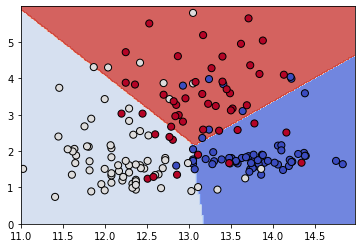

Number of original examples 178
Number of support vectors 81


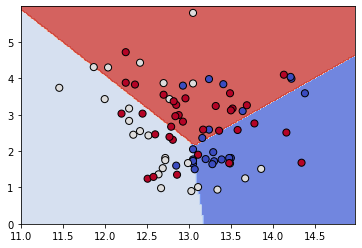


Compare the decision boundaries of the two trained models: are they the same? By the definition of support vectors, they should be!


In [7]:
from sklearn.svm import SVC

# Train a linear SVM
svm = SVC(kernel='linear')
svm.fit(X, y)
plot_classifier(X, y, svm, lims=(11, 15, 0, 6))

# Make a new data set keeping only the support vectors
print("Number of original examples", len(X))
print("Number of support vectors", len(svm.support_))
X_small = X[svm.support_]
y_small = y[svm.support_]

# Train a new SVM using only the support vectors
svm_small = SVC(kernel='linear')
svm_small.fit(X_small, y_small)
plot_classifier(X_small, y_small, svm_small, lims=(11, 15, 0, 6))
print("\nCompare the decision boundaries of the two trained models: are they the same? By the definition of support vectors, they should be!")

## Kernel SVMs

### GridSearchCV warm-up
 we saw that increasing the RBF kernel hyperparameter `gamma` increases training accuracy. Now we'll search for the `gamma` that maximizes cross-validation accuracy using scikit-learn's `GridSearchCV`. A binary version of the handwritten digits dataset, in which you're just trying to predict whether or not an image is a "2", is already loaded into the variables X and y.

In [8]:
X = pd.read_csv('dataset/digits_2_X.csv').to_numpy()
y = pd.read_csv('dataset/digits_2_y.csv').astype('bool').to_numpy().ravel()

In [10]:
from sklearn.model_selection import GridSearchCV

# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and runt the search
parameters = {'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, param_grid=parameters)
searcher.fit(X, y)

# Report the best parameters
print("Best CV params", searcher.best_params_)
print("\nLarger values of gamma are better for training accuracy, but cross-validation helped us find something different (and better!)")

Best CV params {'gamma': 0.001}

Larger values of gamma are better for training accuracy, but cross-validation helped us find something different (and better!)


### Jointly tuning gamma and C with GridSearchCV
In the previous exercise the best value of `gamma` was 0.001 using the default value of `C`, which is 1. In this exercise you'll search for the best combination of `C` and `gamma` using `GridSearchCV`.

As in the previous exercise, the 2-vs-not-2 digits dataset is already loaded, but this time it's split into the variables `X_train`, `y_train`, `X_test`, and `y_test`. Even though cross-validation already splits the training set into parts, it's often a good idea to hold out a separate test set to make sure the cross-validation results are sensible.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, param_grid=parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))
print("\nNote that the best value of gamma, 0.0001, is different from the value of 0.001 that we got in the previous exercise, when we fixed C=1. Hyperparameters can affect each other!")

Best CV params {'C': 10, 'gamma': 0.0001}
Best CV accuracy 1.0
Test accuracy of best grid search hypers: 0.9955555555555555

Note that the best value of gamma, 0.0001, is different from the value of 0.001 that we got in the previous exercise, when we fixed C=1. Hyperparameters can affect each other!


## Comparing logistic regression and SVM (and beyond)
- Logistic regression:
    - Is a linear classifier
    - Can use with kernels, but slow
    - Outputs meaningful probabilities
    - Can be extended to multi-class
    - All data points affect fit
    - L2 or L1 regularization
- Support Vector Machine (SVM)
    - Is a linear classifier
    - Can use with kernels, and fast
    - Does not naturally output probabilities
    - Can be extended to multi-class
    - Only "support vectors" affect fit
    - Conventionally just L2 regularization

### Using SGDClassifier
We do a hyperparameter search over the regularization type, regularization strength, and the loss (logistic regression vs. linear SVM) using `SGDClassifier()`.

In [13]:
from sklearn.linear_model import SGDClassifier

# We set random_state=0 for reproducibility
linear_classifier = SGDClassifier(random_state=0, max_iter=10000)

# Instantiate the GridSearchCV object and run the search
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'loss':['hinge', 'log'],
              'penalty':['l1', 'l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuacy of best grid search hypers:", searcher.score(X_test, y_test))
print("\nOne advantage of SGDClassifier is that it’s very fast – this would have taken a lot longer with LogisticRegression or LinearSVC. ")

C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and 

Best CV params {'alpha': 0.1, 'loss': 'log', 'penalty': 'l2'}
Best CV accuracy 0.9985294117647058
Test accuacy of best grid search hypers: 0.9955555555555555

One advantage of SGDClassifier is that it’s very fast – this would have taken a lot longer with LogisticRegression or LinearSVC. 


C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\dghr201\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and 

In [14]:
from sklearn.linear_model import SGDClassifier

# We set random_state=0 for reproducibility
linear_classifier = SGDClassifier(random_state=0, max_iter=10000)

# Instantiate the GridSearchCV object and run the search
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'loss':['hinge', 'log_loss']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuacy of best grid search hypers:", searcher.score(X_test, y_test))
print("\nOne advantage of SGDClassifier is that it’s very fast – this would have taken a lot longer with LogisticRegression or LinearSVC. ")

Best CV params {'alpha': 0.1, 'loss': 'log_loss'}
Best CV accuracy 0.9985294117647058
Test accuacy of best grid search hypers: 0.9955555555555555

One advantage of SGDClassifier is that it’s very fast – this would have taken a lot longer with LogisticRegression or LinearSVC. 
